## LangGraph with routing

In this example we show you how to create an agent with routing using:
* **OCI Generative AI** (Cohere command-r-plus)
* **LangGraph**

The agent can take three different kinds of requests:
* **Meetings info** 
* **Places info**
* **Not defined**

In [1]:
from types import SimpleNamespace
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from IPython.display import Image, display, Markdown
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END


# to visualize the ds returned from SQL query
import pandas as pd

from config_reader import ConfigReader

# STEP_OPTIONS is the list of possible outcomes
from router import Router, STEP_OPTIONS
from oci_models import create_model_for_answer_directly
from prompts_library import PROMPT_NOT_DEFINED, PROMPT_PLACES_INFO
from utils import get_console_logger

In [2]:
DEBUG = False

# reading the configuration
config = ConfigReader("config.toml")

# logging
logger = get_console_logger()

In [3]:
# agent for tools (it is a multi-agent)

# router
router = Router()

# model for answer directly
llm_d = create_model_for_answer_directly()

In [4]:
#
# tools definition
#
# State
class State(TypedDict):
    """
    Defines the internal state of the agent
    """

    input: str
    decision: Literal[STEP_OPTIONS]
    output: str
    data: list
    output_tool: str


# Nodes
def handle_meetings_info(state: State):
    """meetings_info"""

    logger.info("Called handle_meetings_info...")

    result = SimpleNamespace(content=f"This are the meetings info: meetings xyz!")

    return {"output": result.content, "output_tool": "meetings_info"}
    
def handle_places_info(state: State):
    """meeting_info"""

    logger.info("Called handle_places_info...")

    messages = [
        SystemMessage(content=PROMPT_PLACES_INFO),
        HumanMessage(content=state["input"]),
    ]

    result = llm_d.invoke(input=messages)

    return {"output": result.content, "output_tool": "places_info"}
    
def handle_not_defined(state: State):
    """handle not_defined"""

    logger.info("Called handle_not_defined...")

    messages = [
        SystemMessage(content=PROMPT_NOT_DEFINED),
        HumanMessage(content=state["input"]),
    ]

    result = llm_d.invoke(input=messages)

    return {"output": result.content, "output_tool": "not_defined"}

#### test the router

In [5]:
def test_router(query: str):
    # set the input
    state_test = State(input=query)

    outcome = router.route(state_test)

    return outcome


#
# Battery of tests
#
queries = [
    "I want information about restaurants",
    "I need the list of the meetings of last week",
    "When I have one hour free next week?",
    "When was the last time I went for dentist's appointment?",
    "I want to know what I don't know",
    "When did I meet Ansh (Young Boy)?",
    "When in this week I will be free for lunch/dinner?"
]

for query in queries:
    try:
        print("")

        outcome = test_router(query)

        print("The request is: ", query)
        print("Router decision is: ", outcome)
    except Exception as e:
        print(e)


The request is:  I want information about restaurants
Router decision is:  {'decision': 'places_info'}

The request is:  I need the list of the meetings of last week
Router decision is:  {'decision': 'meetings_info'}

The request is:  When I have one hour free next week?
Router decision is:  {'decision': 'meetings_info'}

The request is:  When was the last time I went for dentist's appointment?
Router decision is:  {'decision': 'meetings_info'}

The request is:  I want to know what I don't know
Router decision is:  {'decision': 'not_defined'}

The request is:  When did I meet Ansh (Young Boy)?
Router decision is:  {'decision': 'meetings_info'}

The request is:  When in this week I will be free for lunch/dinner?
Router decision is:  {'decision': 'meetings_info'}


### define the graph of the agent

In [6]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    """
    return only the next step name
    """
    return state["decision"]


# the aggregator
def aggregator(state: State):
    """Aggregate and refine the output"""

    # for now, only logging
    logger.info("aggregator: Aggregating outputs...")


# Build workflow graph
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("handle_meetings_info", handle_meetings_info)
router_builder.add_node("handle_places_info", handle_places_info)
router_builder.add_node("handle_not_defined", handle_not_defined)

router_builder.add_node("aggregator", aggregator)
router_builder.add_node("router", router.route)

# Add edges to connect nodes
router_builder.add_edge(START, "router")

router_builder.add_conditional_edges(
    "router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "places_info": "handle_places_info",
        "meetings_info": "handle_meetings_info",
        "not_defined": "handle_not_defined",
    },
)

router_builder.add_edge("handle_places_info", "aggregator")
router_builder.add_edge("handle_meetings_info", "aggregator")
router_builder.add_edge("handle_not_defined", "aggregator")
router_builder.add_edge("aggregator", END)

# Compile workflow
router_workflow = router_builder.compile()

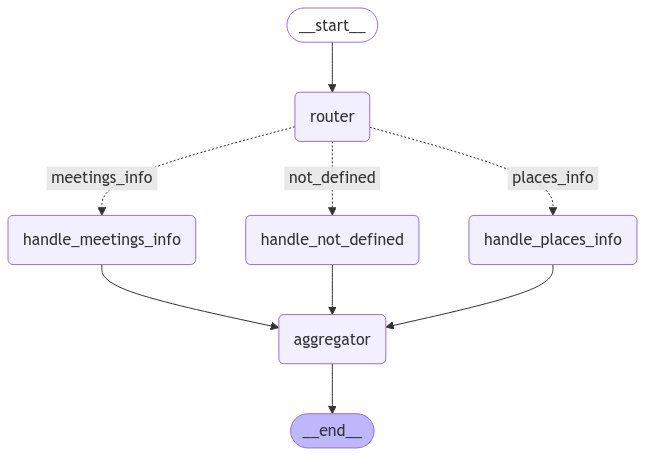

In [7]:
# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

### Tests

In [8]:
# function to simplify the tests
def test_workflow(query: str):
    state = router_workflow.invoke({"input": query})

    if DEBUG:
        print(state)

    return state["output"], state["output_tool"]

### Meeting info

In [9]:
query = """Send me the details of meeting with that Synergy company?"""

outcome, output_tool = test_workflow(query)

# output tool enable to adapt the way the output is shown
if output_tool == "meetings_info":
    print(outcome)

2025-02-27 21:48:51,368 - Called handle_meetings_info...
2025-02-27 21:48:51,370 - aggregator: Aggregating outputs...


This are the meetings info: meetings xyz!


### Places info

In [10]:
query = "Send me list of the top 10 chinese restaurants in London"

outcome, output_tool = test_workflow(query)

if output_tool == "places_info":
    display(Markdown(outcome))

2025-02-27 21:48:58,150 - Called handle_places_info...
2025-02-27 21:49:05,623 - aggregator: Aggregating outputs...


### Top 10 Chinese Restaurants in London
To provide you with an accurate list, I would like to clarify that the ranking of top Chinese restaurants can vary depending on personal preferences, reviews, and ratings. However, based on general reviews and ratings, here is a list of 10 highly-recommended Chinese restaurants in London:

1. **Din Tai Fung**: A popular Taiwanese restaurant with a Michelin star, known for its xiaolongbao and other Taiwanese dishes.
2. **Hakkasan**: A high-end Chinese restaurant with a Michelin star, offering modern Cantonese cuisine.
3. **Xu**: A Taiwanese restaurant in Soho, serving traditional dishes with a modern twist.
4. **Park Chinois**: A luxurious Chinese restaurant in Mayfair, offering a range of Cantonese and Szechuan dishes.
5. **The Delaunay**: A grand café serving Chinese and European-inspired dishes, including dim sum and noodles.
6. **Min Jiang**: A Chinese restaurant located in the Royal Garden Hotel, offering Szechuan and Cantonese cuisine.
7. **Chai Wu**: A modern Chinese restaurant in Harrods, serving a range of dishes including dim sum and noodles.
8. **Golden Dragon**: A traditional Chinese restaurant in Chinatown, offering a range of Cantonese dishes.
9. **Jen Cafe**: A family-run Chinese restaurant in Chinatown, serving traditional dishes including roast meats and noodles.
10. **Four Seasons**: A popular Chinese restaurant with multiple locations in London, offering a range of Cantonese dishes including roast meats and dim sum.

### Please note:
This list is subject to change and may not reflect the current ranking or availability of these restaurants. I recommend checking reviews and making reservations in advance to ensure a smooth dining experience.

If you have any specific preferences (e.g. location, cuisine type, price range), I would be happy to provide a more tailored list.

### not defined

In [11]:
query = "I want to ask something but I don't have a clear idea"

outcome, output_tool = test_workflow(query)

if output_tool == "not_defined":
    display(Markdown(outcome))

2025-02-27 21:49:24,031 - Called handle_not_defined...
2025-02-27 21:49:25,814 - aggregator: Aggregating outputs...


### Reported Question
The user's question is: "I want to ask something but I don't have a clear idea".

### Request for Clarification
To better assist you, could you please provide more context or information about the topic you are interested in? This will help me narrow down the possibilities and provide a more accurate response. What general area or subject are you thinking of inquiring about (e.g., technology, science, history, etc.)?